In [1]:

# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import pickle
# import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
fpX = np.float32
device = 'cpu:0'

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"


In [2]:
ims2use = [625,665]

In [3]:
from feature_extraction import sketch_token_features
which_prf_grid=7;
subject = 1;
_feature_extractor = sketch_token_features.sketch_token_feature_extractor(subject=subject, device=device,\
                 which_prf_grid=which_prf_grid)
    

In [5]:
from utils import numpy_utils, torch_utils, stats_utils, default_paths, roi_utils, prf_utils
from model_fitting import initialize_fitting

import scipy.stats
trials2do = np.arange(0,2)

aperture, prf_models = initialize_fitting.get_prf_models(aperture_rf_range=1.1, which_grid=which_prf_grid)
images = ims2use
zscore=True
debug=False
dtype=np.float32

image_size = None
_feature_extractor.init_for_fitting(image_size=image_size, models=prf_models, dtype=fpX)

number of pRFs: 625
most extreme RF positions:
[-0.52 -0.52  0.04]
[0.52 0.52 0.04]
Initializing for fitting
Clearing features from memory


In [6]:
from utils import nsd_utils
images_actual = nsd_utils.get_image_data(subject=subject);


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


In [7]:
images_actual_used = images_actual[images]

In [10]:
volume_space=True
roi_def = roi_utils.get_combined_rois(subject, volume_space=volume_space, \
                                      include_all=True, include_body=True, verbose=False)

In [13]:
# params = best_params
# best_models, weights, bias, features_mt, features_st, best_model_inds = params  
device = _feature_extractor.device

n_trials = len(images)
# n_trials, n_voxels = len(images), len(best_models)
n_prfs = prf_models.shape[0]
n_features = _feature_extractor.max_features
n_features_max = n_features
# n_voxels = np.shape(voxel_data)[1]
map_res = 240;


In [14]:
from scipy.io import loadmat
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
feature_ims = clust['clusters']['clusters'][0][0]
feature_ims = np.moveaxis(feature_ims, [0,1,2],[1,0,2])

In [15]:
import copy
thresh = 0.08
feature_ims_adj = copy.deepcopy(feature_ims)
feature_ims_adj[feature_ims<thresh] = 0
# feature_ims_adj[feature_ims>thresh] = 1

In [16]:
path_to_toolbox = os.path.join('/user_data/mmhender/toolboxes','StructuredForests')
sys.path.append(path_to_toolbox)
from utils import nms_utils

/home/mmhender/myenv/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /user_data/mmhender/toolboxes/StructuredForests/_StructuredForests.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [17]:
thinned_feature_ims = nms_utils.apply_nms(feature_ims[:,np.newaxis,:,:])[:,0,:,:]
# thinned_feature_ims = apply_nms(feature_ims_adj[:,np.newaxis,:,:])[:,0,:,:]

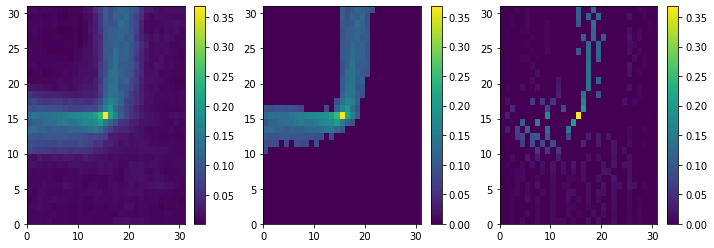

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4));
plt.subplot(1,3,1)
plt.pcolormesh(feature_ims[:,:,50])
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(feature_ims_adj[:,:,50])
# plt.pcolormesh(thinned_feature_ims[:,:,50])
plt.colorbar()
plt.subplot(1,3,3)
plt.pcolormesh(feature_ims_adj[:,:,50])
plt.pcolormesh(thinned_feature_ims[:,:,50])
plt.colorbar()

In [19]:
feature_ims = feature_ims_adj

In [20]:
import skimage.transform

def get_feature_patches_positioned(x,y,feature_ims, map_res=240, scale_patch_size=False, max_patch_size=100):

    n_pix = map_res
    n_pix_padded = map_res*4
    n_pad = int(np.floor((n_pix_padded-n_pix)/2))
    # center goes [row ind, col ind]
    center = np.array((n_pix_padded/2  - y*n_pix, x*n_pix + n_pix_padded/2)) 
    # note that the x/y dims get swapped here
    center = np.ceil(center).astype('int')
    assert(np.all(center>=0) & np.all(center<=(n_pix_padded-1)))

    if not scale_patch_size:
        npix_patch = int(np.round(31/227*map_res))
    else:
        npix_patch = int(np.ceil(sigma*n_pix*2))
        npix_patch = np.min([npix_patch, max_patch_size])

    if feature_ims.shape[0]!=npix_patch:
        n_features = feature_ims.shape[2]
        feature_ims_scaled = skimage.transform.resize(feature_ims, \
                                       [npix_patch, npix_patch, n_features], anti_aliasing=True)

    
    xmin = int(center[0]-np.floor(npix_patch)/2)
    xmax = int(center[0]+np.ceil(npix_patch)/2)
    ymin = int(center[1]-np.floor(npix_patch)/2)
    ymax = int(center[1]+np.ceil(npix_patch)/2)

    bbox = [xmin, xmax, ymin, ymax]
 
    features_padded = np.zeros((n_pix_padded, n_pix_padded, n_features))
    features_padded[bbox[0]:bbox[1], bbox[2]:bbox[3],:] = feature_ims_scaled
    features_unpadded = features_padded[n_pad:n_pad+n_pix,n_pad:n_pad+n_pix,:] 

    mask_padded = np.zeros((n_pix_padded, n_pix_padded))
    mask_padded[bbox[0]:bbox[1], bbox[2]:bbox[3]] = 1
    mask_unpadded = mask_padded[n_pad:n_pad+n_pix,n_pad:n_pad+n_pix]
    
    return features_unpadded, mask_unpadded

    

90


(0.0, 240.0, 0.0, 240.0)

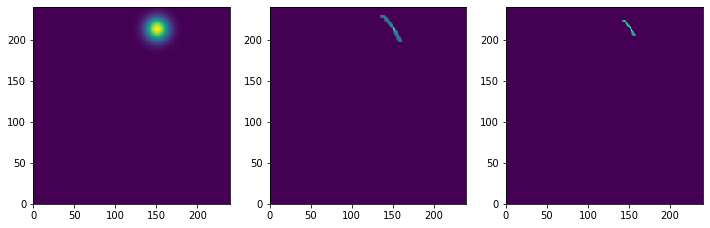

In [21]:
# mm = np.where((np.round(prf_models[:,0],1)==0.2) & (np.round(prf_models[:,1],1)==0.1) & (np.round(prf_models[:,2],1)==0.1))[0][0]
# mm = np.where((np.round(prf_models[:,0],2)==-0.33) & (np.round(prf_models[:,1],2)==-0.33) & (np.round(prf_models[:,2],1)==0.1))[0][0]

# mm=1400
mm=90
print(mm)
prf_models[mm,:]

features_tiled = np.zeros((n_trials, n_features, map_res, map_res))
x,y,sigma = prf_models[mm,:]

features_positioned, mask = get_feature_patches_positioned(x,y,feature_ims, \
                                                           map_res=240, scale_patch_size=False)
features_positioned_scaled, mask_scaled = get_feature_patches_positioned(x,y,feature_ims, \
                                                           map_res=240, scale_patch_size=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4));

x,y,sigma = prf_models[mm,:]
prf = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=map_res)
plt.subplot(1,3,1)
plt.pcolormesh(prf)
plt.axis('square')

plt.subplot(1,3,2)
plt.pcolormesh(features_positioned[:,:,20])
plt.axis('square')

plt.subplot(1,3,3)
plt.pcolormesh(features_positioned_scaled[:,:,20])
plt.axis('square')

In [22]:
features_pos = []
feature_masks = []
for mm in range(len(prf_models)):
# for mm in np.arange(1101, 1200):
    
    x,y,sigma = prf_models[mm,:]
#     features_positioned, mask = get_feature_patches_positioned(x,y,feature_ims,\
#                                                map_res=240, scale_patch_size=True, max_patch_size=35)
    features_positioned, mask = get_feature_patches_positioned(x,y,feature_ims,\
                                               map_res=240, scale_patch_size=False, max_patch_size=35)
    features_pos.append(features_positioned)
    feature_masks.append(mask)
    if np.mod(mm, 100)==0:
        print(mm)

0
100
200
300
400
500
600


In [23]:
import h5py
t = time.time()
# Loading raw sketch tokens features.
with h5py.File(_feature_extractor.features_file, 'r') as data_set:
    values = np.copy(data_set['/features'][images,:,:])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)

all_feat_concat = values[:,0:150,:]

# using mean and std that were computed on training set during fitting - keeping 
# these pars constant here seems to improve fits. 
tiled_mean = np.tile(features_mt.T[np.newaxis,:,:], [n_trials, 1, 1])
tiled_std = np.tile(features_st.T[np.newaxis,:,:], [n_trials, 1, 1])
pred_models = (all_feat_concat - tiled_mean)/tiled_std

# pred_models = all_feat_concat
feature_inds_defined_each_prf = np.ones((150,n_prfs))==1

Took 0.15869 seconds to load file


NameError: name 'features_mt' is not defined

[107 145  90  40  51  60 125  93  35 136]


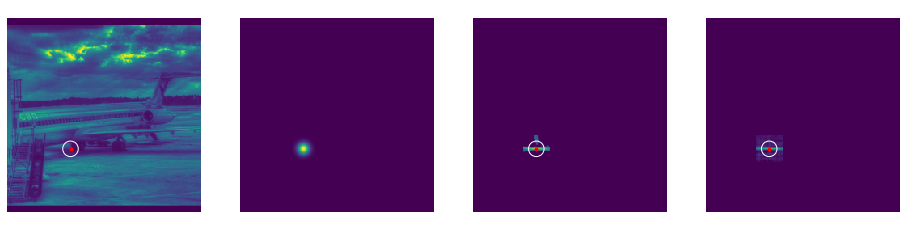

In [67]:
import matplotlib
# mm = 478
# mm=400
# mm = 486
# mm = 518
mm=90
# mm=600
# mm = 461
ii=1

features = pred_models[ii,:,mm]
ff2plot = np.flip(np.argsort(features))[1]
ff2use = np.flip(np.argsort(features))[0:10]
print(ff2use)
features_weighted_sum = features_pos[mm][:,:,ff2use] @ features[ff2use]


n_pix = 240
x,y,sigma = prf_models[mm,:]
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix


plt.figure(figsize=(16,4));
ax = plt.subplot(1,4,1);
plt.pcolormesh(images_actual_used[ii,0,:,:])
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()
plt.plot(center_in_image[0], center_in_image[1],'.',color='r')
circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
ax.add_artist(circ)

plt.subplot(1,4,2)
prf = prf_utils.gauss_2d(center=[x,y], sd=sigma,patch_size=n_pix)
plt.pcolormesh(prf)
plt.axis('square')
plt.axis('off')
plt.gca().invert_yaxis()


n_pix = 240
x,y,sigma = prf_models[mm,:]
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix


ax = plt.subplot(1,4,3)
plt.pcolormesh(features_pos[mm][:,:,ff2plot])
plt.gca().invert_yaxis()
plt.axis('equal')
plt.axis('off')
plt.plot(center_in_image[0], center_in_image[1],'.',color='r')
circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
ax.add_artist(circ)

ax = plt.subplot(1,4,4)
plt.pcolormesh(features_weighted_sum)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.axis('off')
plt.plot(center_in_image[0], center_in_image[1],'.',color='r')
circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
ax.add_artist(circ)

In [68]:
feat_ignore = [107]
feat_use = ~np.isin(np.arange(n_features), feat_ignore);
activ_use = copy.deepcopy(pred_models[:,feat_use,:])


In [69]:
np.unique(prf_models[:,2])

array([0.02      , 0.03088904, 0.04770664, 0.07368063, 0.1137962 ,
       0.17575279, 0.27144176, 0.4192288 , 0.6474788 , 1.        ],
      dtype=float32)

In [70]:
# Reconstruct based only on top feature at each position.

# prfs2use = np.arange(n_prfs);
prfs2use = np.where(prf_models[:,2]<0.10)[0]
# prfs2use = np.where(prf_models[:,2]<0.03)[0]

recon_actual = np.zeros((n_trials, map_res, map_res));

sum_blank_patches = np.sum(np.array(feature_masks)[prfs2use], axis=0);

for mi, mm in tqdm(enumerate(prfs2use)): 
    
    features_positioned_use = features_pos[mm][:,:,feat_use];
#     features_positioned_use = features_positioned

    activ_this_prf = activ_use[:,:,mm];
    
    top_feature = np.argmax(activ_this_prf, axis=1);

    for tt in range(n_trials):        
        recon_actual[tt,:,:] += features_positioned_use[:,:,top_feature[tt]] * activ_this_prf[tt,top_feature[tt]]

recon_normalized = recon_actual/sum_blank_patches;
recon_normalized[np.isnan(recon_normalized)] = 0;

528it [00:34, 15.34it/s]
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


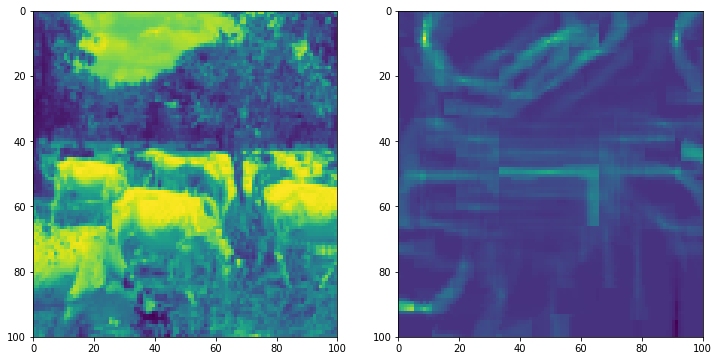

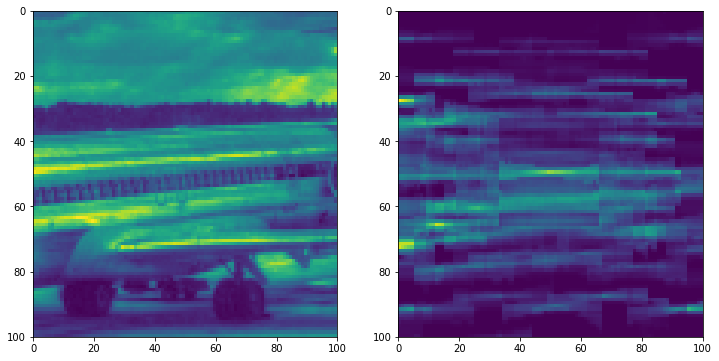

In [81]:
# Without scaling
central_crop_size = 100;
plot_limits = np.array([(n_pix-central_crop_size)/2, (n_pix-(n_pix-central_crop_size)/2)]).astype(int)
for ii in range(n_trials):
    
    plt.figure(figsize=(12,6));
    
    plt.subplot(1,2,1);
    plt.pcolormesh(images_actual_used[ii,0,plot_limits[0]:plot_limits[1],plot_limits[0]:plot_limits[1]])
    
#     plt.xlim(plot_limits)
#     plt.ylim(plot_limits)
    plt.gca().invert_yaxis()
    
    plt.subplot(1,2,2);
#     plt.pcolormesh(recon_actual[ii,:,:])
    plt.pcolormesh(recon_normalized[ii,plot_limits[0]:plot_limits[1],plot_limits[0]:plot_limits[1]])
#     plt.xlim(plot_limits)
#     plt.ylim(plot_limits)
    plt.gca().invert_yaxis()


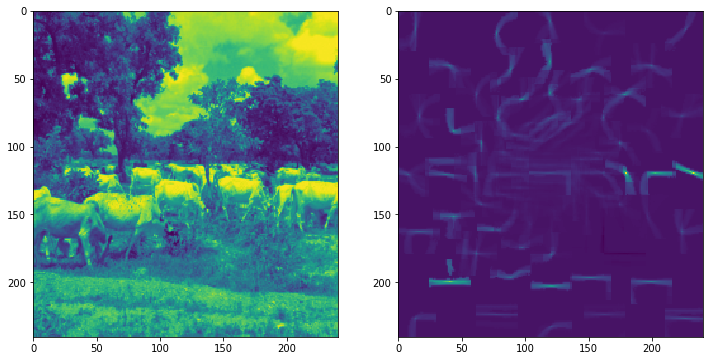

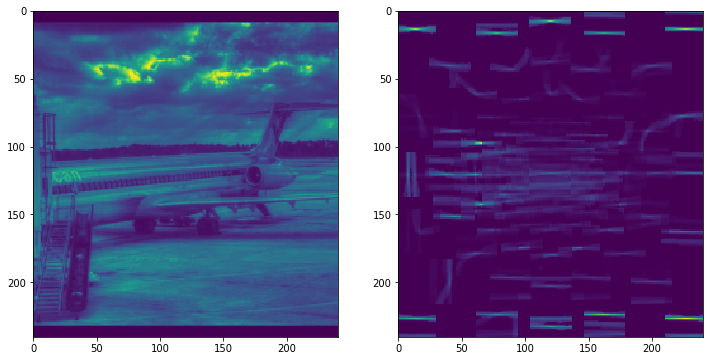

In [80]:
# Without scaling

for ii in range(n_trials):
    
    plt.figure(figsize=(12,6));
    
    plt.subplot(1,2,1);
    plt.pcolormesh(images_actual_used[ii,0,:,:])
    plt.gca().invert_yaxis()
    
    plt.subplot(1,2,2);
#     plt.pcolormesh(recon_actual[ii,:,:])
    plt.pcolormesh(recon_normalized[ii,:,:])
    plt.gca().invert_yaxis()


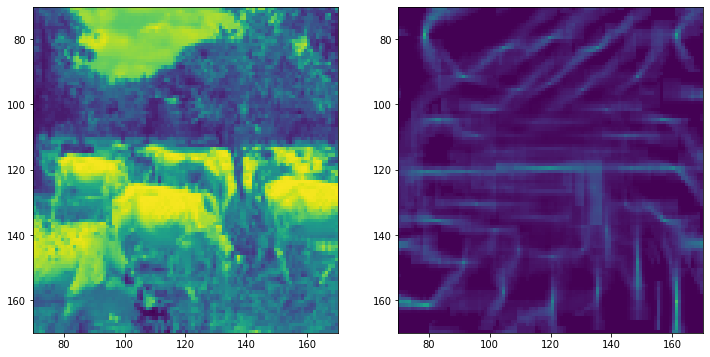

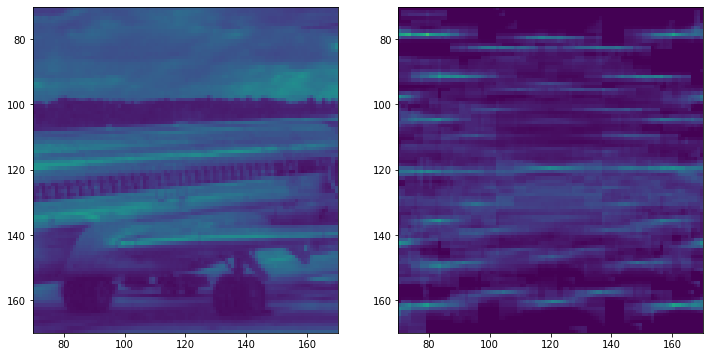

In [31]:
# With scaling
central_crop_size = 100;
plot_limits = np.array([(n_pix-central_crop_size)/2, (n_pix-(n_pix-central_crop_size)/2)]).astype(int)
for ii in range(n_trials):
    
    plt.figure(figsize=(12,6));
    
    plt.subplot(1,2,1);
    plt.pcolormesh(images_actual_used[ii,0,:,:])
    
    plt.xlim(plot_limits)
    plt.ylim(plot_limits)
    plt.gca().invert_yaxis()
    
    plt.subplot(1,2,2);
#     plt.pcolormesh(recon_actual[ii,:,:])
    plt.pcolormesh(recon_normalized[ii,:,:])
    plt.xlim(plot_limits)
    plt.ylim(plot_limits)
    plt.gca().invert_yaxis()


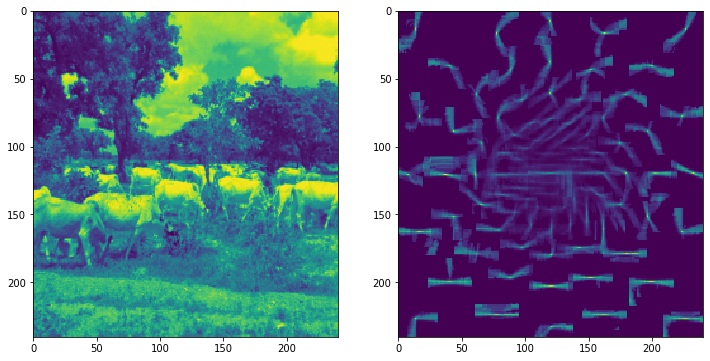

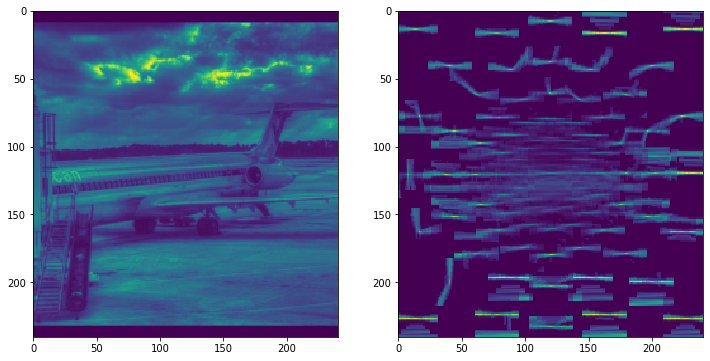

In [32]:
# With scaling

for ii in range(n_trials):
    
    plt.figure(figsize=(12,6));
    
    plt.subplot(1,2,1);
    plt.pcolormesh(images_actual_used[ii,0,:,:])
    plt.gca().invert_yaxis()
    
    plt.subplot(1,2,2);
#     plt.pcolormesh(recon_actual[ii,:,:])
    plt.pcolormesh(recon_normalized[ii,:,:])
    plt.gca().invert_yaxis()


In [73]:
# Reconstruct based only on top feature each location. 
# within spatial scale.

scales = np.unique(prf_models[:,2])
# n_scales = len(scales)
n_scales = 3

recon_actual_each_scale = np.zeros((n_trials, map_res, map_res, n_scales));
recon_normalized_each_scale = np.zeros((n_trials, map_res, map_res, n_scales));

pp = 0;
for sc in range(n_scales):
    
    prfs2use = np.where(prf_models[:,2]==scales[sc])[0]

    sum_blank_patches = np.sum(np.array(feature_masks)[prfs2use], axis=0);

    for mi, mm in tqdm(enumerate(prfs2use)): 

        features_positioned_use = features_pos[mm][:,:,feat_use];
    #     features_positioned_use = features_positioned

        activ_this_prf = activ_use[:,:,mm];

        top_feature = np.argmax(activ_this_prf, axis=1);

        for tt in range(n_trials):        
            recon_actual_each_scale[tt,:,:,sc] += features_positioned_use[:,:,top_feature[tt]] * activ_this_prf[tt,top_feature[tt]];

    recon_normalized_each_scale[:,:,:,sc] = recon_actual_each_scale[:,:,:,sc]/sum_blank_patches;
    
recon_normalized_each_scale[np.isnan(recon_normalized_each_scale)] = 0;

132it [00:08, 16.02it/s]
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
132it [00:08, 16.13it/s]
132it [00:08, 15.81it/s]


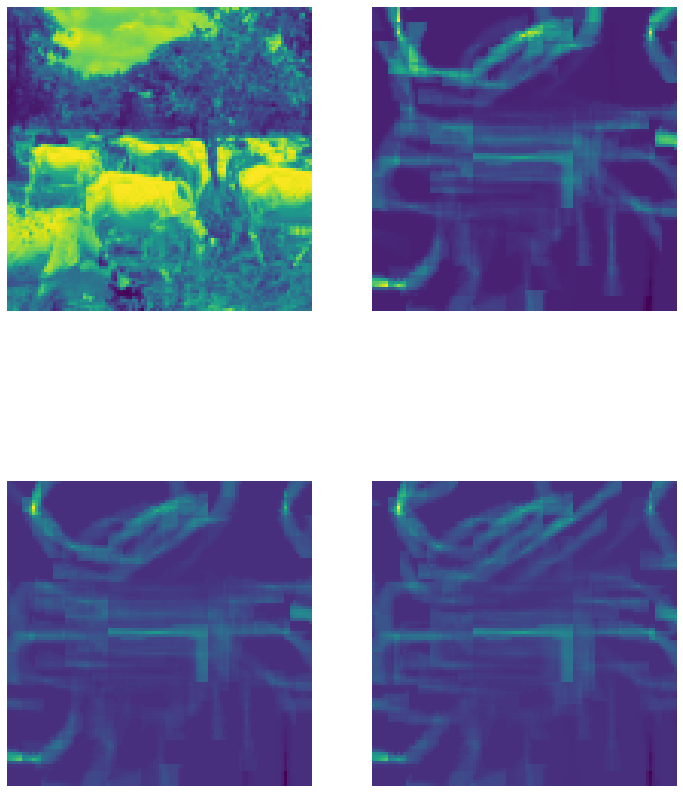

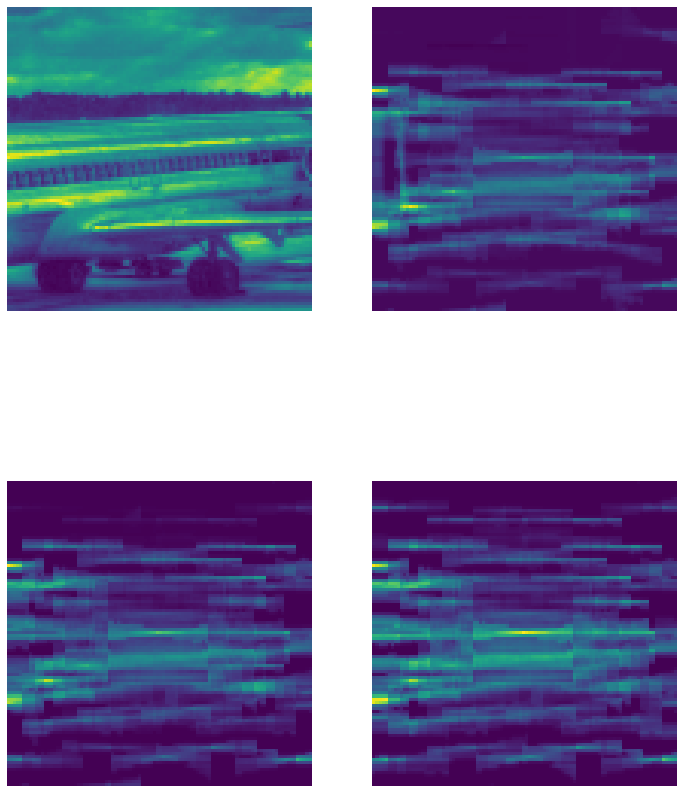

In [82]:
# without scaling of features
sc2plot = np.arange(3)
n_scales = len(sc2plot)
central_crop_size = 100;
plot_limits = np.array([(n_pix-central_crop_size)/2, (n_pix-(n_pix-central_crop_size)/2)]).astype(int)

npx = int(np.ceil(np.sqrt(n_scales)))
npy = int(np.ceil(n_scales/npx))

for ii in range(n_trials):
    
    plt.figure(figsize=(12,16));
    
    plt.subplot(npx, npy,1);
    plt.pcolormesh(images_actual_used[ii,0,plot_limits[0]:plot_limits[1],plot_limits[0]:plot_limits[1]])   
    plt.axis('square')
    plt.axis('off')
#     plt.xlim(plot_limits)
#     plt.ylim(plot_limits)
    plt.gca().invert_yaxis()
    
    for sc in range(n_scales):
    
        plt.subplot(npx, npy,sc+2);
        plt.pcolormesh(recon_normalized_each_scale[ii,plot_limits[0]:plot_limits[1],plot_limits[0]:plot_limits[1],sc])
        plt.axis('square')
        plt.axis('off')
#         plt.xlim(plot_limits)
#         plt.ylim(plot_limits)
        plt.gca().invert_yaxis()


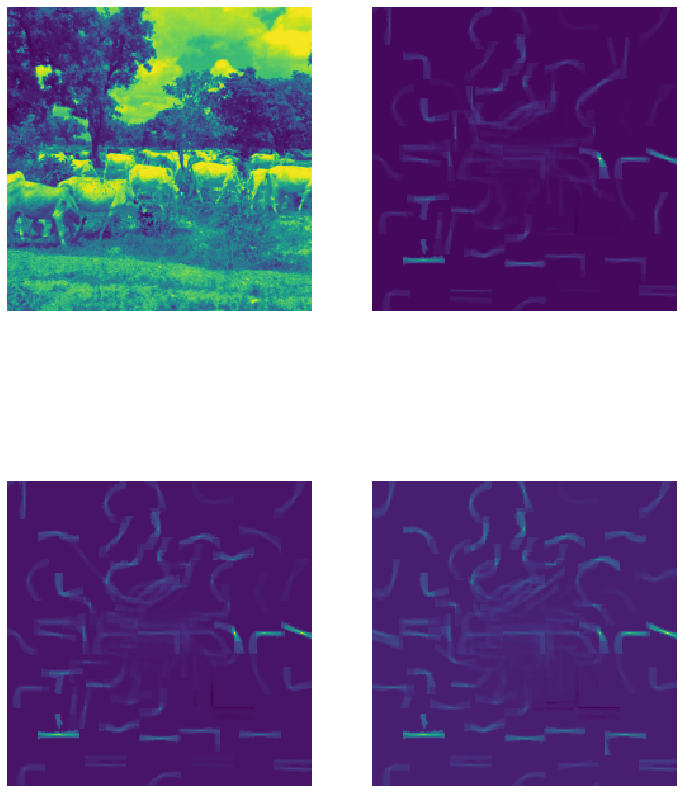

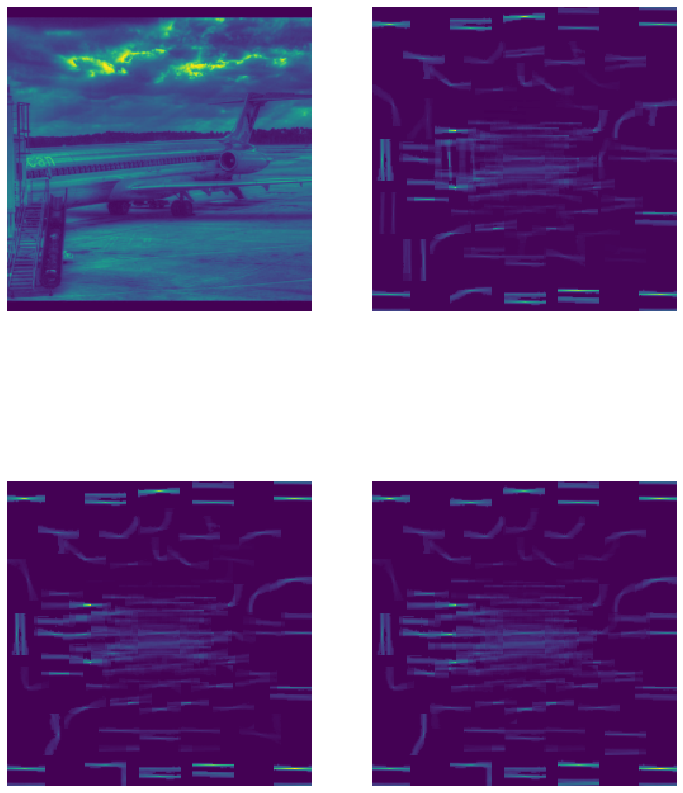

In [83]:
# without scaling of features

npx = int(np.ceil(np.sqrt(n_scales)))
npy = int(np.ceil(n_scales/npx))

for ii in range(n_trials):
    
    plt.figure(figsize=(12,16));
    
    plt.subplot(npx, npy,1);
    plt.pcolormesh(images_actual_used[ii,0,:,:])   
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    
    for sc in range(n_scales):
    
        plt.subplot(npx, npy,sc+2);
        plt.pcolormesh(recon_normalized_each_scale[ii,:,:,sc])
        plt.axis('square')
        plt.axis('off')
        plt.gca().invert_yaxis()


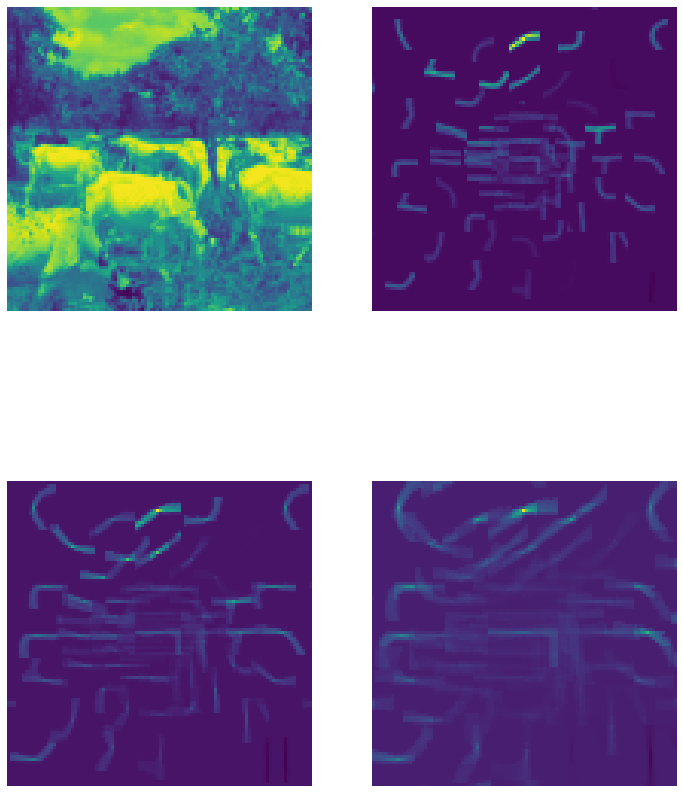

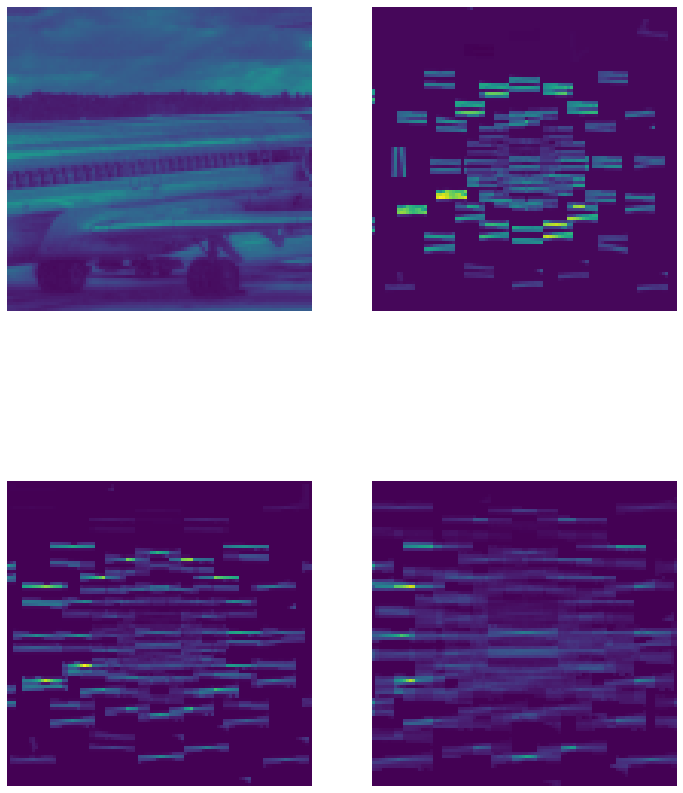

In [64]:
# with scaling of features
sc2plot = np.arange(3)
n_scales = len(sc2plot)
central_crop_size = 100;
plot_limits = np.array([(n_pix-central_crop_size)/2, (n_pix-(n_pix-central_crop_size)/2)]).astype(int)

npx = int(np.ceil(np.sqrt(n_scales)))
npy = int(np.ceil(n_scales/npx))

for ii in range(n_trials):
    
    plt.figure(figsize=(12,16));
    
    plt.subplot(npx, npy,1);
    plt.pcolormesh(images_actual_used[ii,0,:,:])   
    plt.axis('square')
    plt.axis('off')
    plt.xlim(plot_limits)
    plt.ylim(plot_limits)
    plt.gca().invert_yaxis()
    
    for sc in range(n_scales):
    
        plt.subplot(npx, npy,sc+2);
        plt.pcolormesh(recon_normalized_each_scale[ii,:,:,sc])
        plt.axis('square')
        plt.axis('off')
        plt.xlim(plot_limits)
        plt.ylim(plot_limits)
        plt.gca().invert_yaxis()


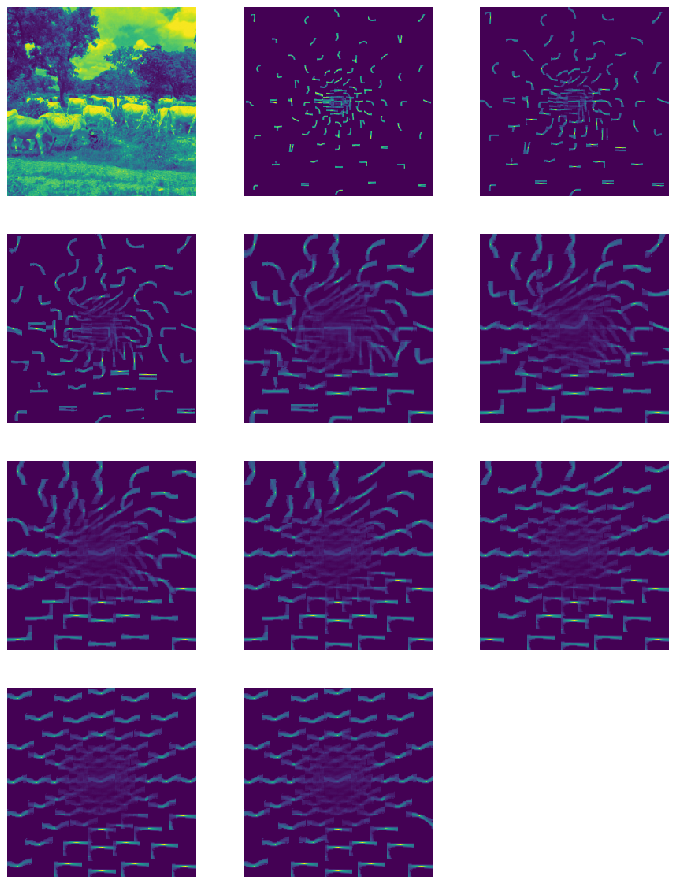

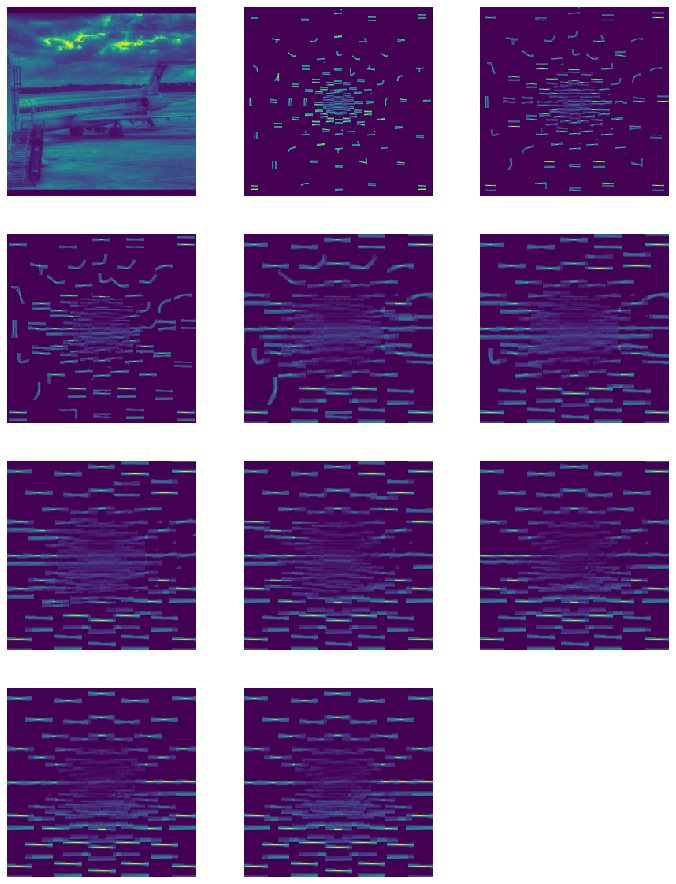

In [45]:
# with scaling of features

npx = int(np.ceil(np.sqrt(n_scales)))
npy = int(np.ceil(n_scales/npx))

for ii in range(n_trials):
    
    plt.figure(figsize=(12,16));
    
    plt.subplot(npx, npy,1);
    plt.pcolormesh(images_actual_used[ii,0,:,:])   
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    
    for sc in range(n_scales):
    
        plt.subplot(npx, npy,sc+2);
        plt.pcolormesh(recon_normalized_each_scale[ii,:,:,sc])
        plt.axis('square')
        plt.axis('off')
        plt.gca().invert_yaxis()


In [84]:
# Weighted sum over multiple features

top_n = 10

scales = np.unique(prf_models[:,2])
# n_scales = len(scales)
n_scales = 3

recon_actual_each_scale = np.zeros((n_trials, map_res, map_res, n_scales));
recon_normalized_each_scale = np.zeros((n_trials, map_res, map_res, n_scales));

pp = 0;
for sc in range(n_scales):
    
    prfs2use = np.where(prf_models[:,2]==scales[sc])[0]

    sum_blank_patches = np.sum(np.array(feature_masks)[prfs2use], axis=0);

    for mi, mm in tqdm(enumerate(prfs2use)): 

        features_positioned_use = features_pos[mm][:,:,feat_use];
    #     features_positioned_use = features_positioned

        activ_this_prf = activ_use[:,:,mm];
       
        for tt in range(n_trials):    
            
            top_features = np.flip(np.argsort(activ_this_prf[tt,:], axis=0))[0:top_n]

            recon_actual_each_scale[tt,:,:,sc] += features_positioned_use[:,:,top_features] @ activ_this_prf[tt,top_features];

    recon_normalized_each_scale[:,:,:,sc] = recon_actual_each_scale[:,:,:,sc]/sum_blank_patches;
    
recon_normalized_each_scale[np.isnan(recon_normalized_each_scale)] = 0;

132it [00:08, 15.47it/s]
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
132it [00:08, 15.60it/s]
132it [00:08, 15.08it/s]


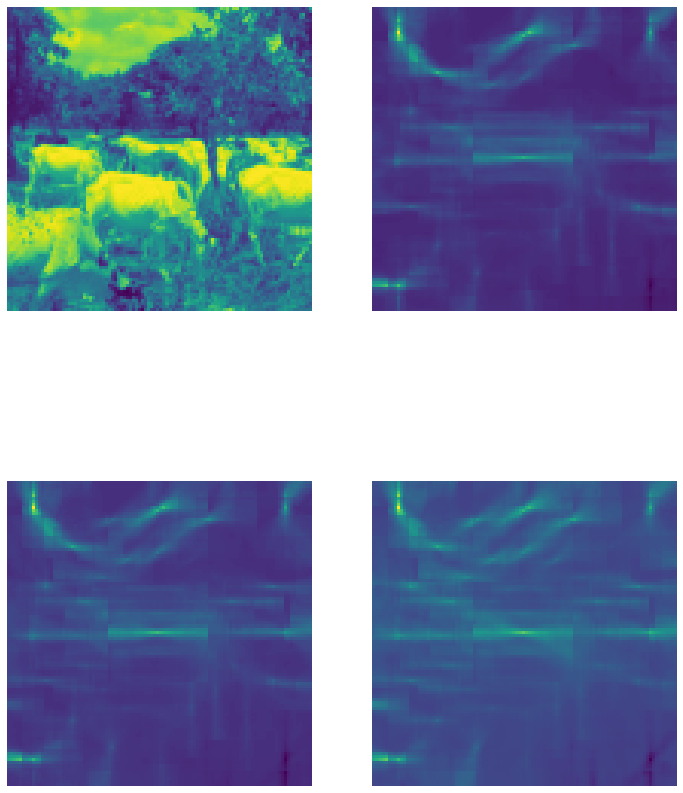

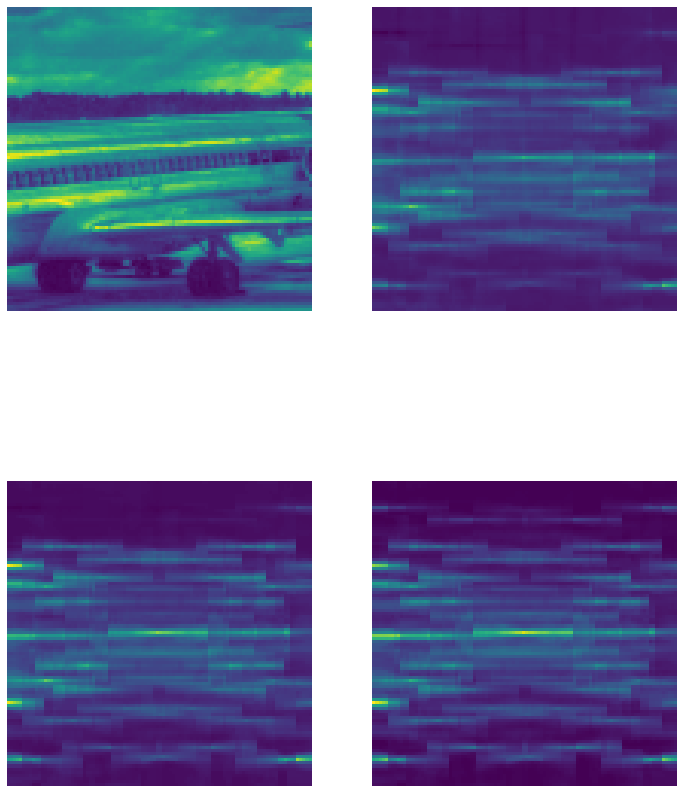

In [85]:
# without scaling of features
sc2plot = np.arange(3)
n_scales = len(sc2plot)
central_crop_size = 100;
plot_limits = np.array([(n_pix-central_crop_size)/2, (n_pix-(n_pix-central_crop_size)/2)]).astype(int)

npx = int(np.ceil(np.sqrt(n_scales)))
npy = int(np.ceil(n_scales/npx))

for ii in range(n_trials):
    
    plt.figure(figsize=(12,16));
    
    plt.subplot(npx, npy,1);
    plt.pcolormesh(images_actual_used[ii,0,plot_limits[0]:plot_limits[1],plot_limits[0]:plot_limits[1]])   
    plt.axis('square')
    plt.axis('off')
#     plt.xlim(plot_limits)
#     plt.ylim(plot_limits)
    plt.gca().invert_yaxis()
    
    for sc in range(n_scales):
    
        plt.subplot(npx, npy,sc+2);
        plt.pcolormesh(recon_normalized_each_scale[ii,plot_limits[0]:plot_limits[1],plot_limits[0]:plot_limits[1],sc])
        plt.axis('square')
        plt.axis('off')
#         plt.xlim(plot_limits)
#         plt.ylim(plot_limits)
        plt.gca().invert_yaxis()


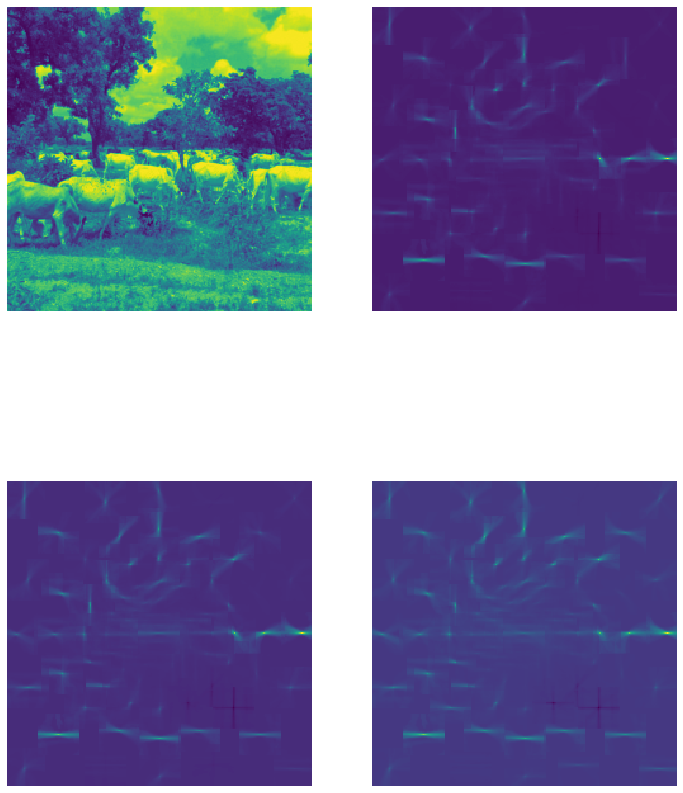

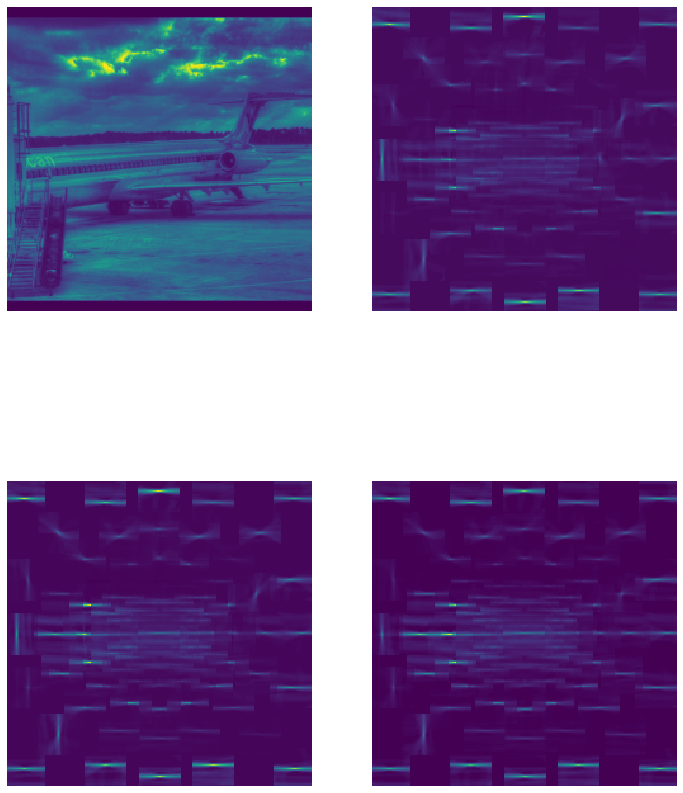

In [86]:
# without scaling of features

npx = int(np.ceil(np.sqrt(n_scales)))
npy = int(np.ceil(n_scales/npx))

for ii in range(n_trials):
    
    plt.figure(figsize=(12,16));
    
    plt.subplot(npx, npy,1);
    plt.pcolormesh(images_actual_used[ii,0,:,:])   
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    
    for sc in range(n_scales):
    
        plt.subplot(npx, npy,sc+2);
        plt.pcolormesh(recon_normalized_each_scale[ii,:,:,sc])
        plt.axis('square')
        plt.axis('off')
        plt.gca().invert_yaxis()
